In [1]:
import pandas as pd
df = pd.read_csv("data/space_embedding_data.csv", index_col=[0])
df.head()

,Grid,PlaceCount,Price 1,Price 2,Price 3,Accommodation,Bar,Cafe,Cultural,Education,...,Health_rating,Other_rating,Outdoors_rating,Restaurant_rating,Retail_rating,Service_rating,Wholesale_rating,PositiveReviews,NegativeReviews,ReviewLength
0,L0,8,0,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.020000,0.0,3.942857,0.000000,0.000000,0.000000,0.696000,0.304000,0.536595
1,L1,10,0,1,0,0.0,0.0,1.0,0.0,0.0,...,5.0,0.000000,0.0,4.777778,0.000000,4.000000,0.000000,0.851852,0.148148,0.802238
2,L10,3,0,0,0,0.0,0.0,0.0,0.0,1.0,...,0.0,4.200000,0.0,0.000000,0.000000,0.000000,0.000000,0.857143,0.142857,0.999095
3,L100,74,2,9,6,12.0,6.0,6.0,0.0,1.0,...,3.6,4.024460,0.0,3.711172,4.500000,3.028846,0.000000,0.732975,0.267025,0.895548
4,L101,163,7,31,5,21.0,19.0,20.0,1.0,1.0,...,4.5,4.223132,0.0,3.748855,3.549446,4.311111,3.722222,0.801535,0.198465,0.843739


In [2]:
#df.fillna(2, inplace=True)

In [3]:
y = df[[i for i in df.columns if "_rating" not in i]].drop(["Grid"], axis=1)
X = pd.get_dummies(df.Grid).values

In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
y_tf = sc.fit_transform(y)

# Model building

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras import Input
# Parameters
input_neurons = X.shape[0] #df.Grid.nunique()
output_neurons = y.shape[1] #df.shape[-1]-1
act_f = 'relu'
hidden_neurons = 2056

# Model architecture
model = Sequential()
model.add(Input(shape=(input_neurons,)))
model.add(Dense(hidden_neurons, activation=act_f))
model.add(Dense(output_neurons, activation=act_f))

In [6]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.01)
model.compile(loss="mean_squared_error", optimizer=opt, metrics=["mean_squared_error"])

batch_size = 12
epochs = 200
history = model.fit(X, y_tf, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/200
40/40 [==============================] - 0s 3ms/step - loss: 1.0021 - mean_squared_error: 1.0021
Epoch 2/200
40/40 [==============================] - 0s 2ms/step - loss: 0.9990 - mean_squared_error: 0.9990
Epoch 3/200
40/40 [==============================] - 0s 2ms/step - loss: 0.9864 - mean_squared_error: 0.9864
Epoch 4/200
40/40 [==============================] - 0s 2ms/step - loss: 0.9514 - mean_squared_error: 0.9514
Epoch 5/200
40/40 [==============================] - 0s 2ms/step - loss: 0.8609 - mean_squared_error: 0.8609
Epoch 6/200
40/40 [==============================] - 0s 2ms/step - loss: 0.7425 - mean_squared_error: 0.7425
Epoch 7/200
40/40 [==============================] - 0s 2ms/step - loss: 0.6797 - mean_squared_error: 0.6797
Epoch 8/200
40/40 [==============================] - 0s 2ms/step - loss: 0.6393 - mean_squared_error: 0.6393
Epoch 9/200
40/40 [==============================] - 0s 3ms/step - loss: 0.5932 - mean_squared_error: 0.5932
Epoch 10/200
40/40 

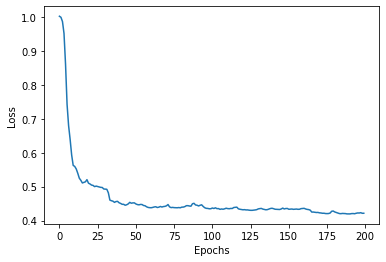

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.epoch, history.history['loss'])
plt.ylabel("Loss")
plt.xlabel("Epochs");

In [8]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X)
mean_squared_error(y_tf, y_pred)

0.4208329530484039

In [9]:
model.layers[0].get_weights()

[array([[ 0.01134083, -0.16404057,  0.00952493, ..., -0.00053272,
         -0.03091468, -0.03499408],
        [-0.09525383,  0.02668817, -0.02657523, ...,  0.04131517,
         -0.02131649,  0.00855051],
        [ 0.00296148,  0.03045608,  0.01837367, ...,  0.03655125,
         -0.04142128, -0.04060674],
        ...,
        [-0.02834114, -0.03939577,  0.08375563, ...,  0.02889028,
          0.09156764, -0.01894287],
        [-0.24081452, -0.01410685, -0.03065039, ...,  0.03769118,
          0.04362059, -0.01870783],
        [ 0.00561729, -0.20646785, -0.02653866, ..., -0.04685046,
          0.00934385, -0.03021444]], dtype=float32),
 array([-0.45894912, -0.55783904, -0.43361044, ..., -0.11465064,
        -0.30060208, -0.28168747], dtype=float32)]

## Optimization

https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/

In [10]:
from sklearn.model_selection import cross_val_score
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [11]:
# Create function
# https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/
def optimize(neurons, activation, learning_rate,  batch_size, epochs):

    activationL = ['relu', 'sigmoid', 'tanh', 'exponential']

    neurons = round(neurons)
    activation = activationL[round(activation)]
    batch_size = round(batch_size)
    epochs = round(epochs)
    

    def build_nn():
        nn = Sequential()
        nn.add(Input(shape=(input_neurons,)))
        nn.add(Dense(hidden_neurons, activation=activation))
        nn.add(Dense(output_neurons, activation='relu'))

        opt = Adam(lr = learning_rate)
        nn.compile(loss="mean_squared_error", optimizer=opt, metrics=["mean_squared_error"])
        
        return nn


    es = EarlyStopping(monitor='mean_squared_error', mode='min', verbose=False, patience=20)

    nn = KerasRegressor(build_fn=build_nn, epochs=epochs, batch_size=batch_size,
                         verbose=False)

    kfold = KFold(n_splits=5, shuffle=True, random_state=123)

    score = cross_val_score(nn, X, y_tf, scoring='neg_mean_squared_error', cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [12]:
params_nn ={
    'neurons': (600, 1000),
    'activation':(0, 3),
    'learning_rate':(0.01, 1),
    'batch_size':(1, 20),
    'epochs':(100, 300)
}

# Run Bayesian Optimization
nn_bo = BayesianOptimization(optimize, params_nn, random_state=123)
nn_bo.maximize(init_points=5, n_iter=4)

|   iter    |  target   | activa... | batch_... |  epochs   | learni... |  neurons  |
-------------------------------------------------------------------------------------
|  1        | -1.0      |  2.089    |  6.437    |  145.4    |  0.5558   |  887.8    |
|  2        | -1.0      |  1.269    |  19.63    |  237.0    |  0.4861   |  756.8    |
|  3        | -1.0      |  1.03     |  14.85    |  187.7    |  0.06908  |  759.2    |
|  4        | -1.0      |  2.214    |  4.467    |  135.1    |  0.5362   |  812.7    |
|  5        | -1.0      |  1.903    |  17.14    |  244.9    |  0.6149   |  889.0    |
|  6        | -1.0      |  2.44     |  4.719    |  104.6    |  0.7045   |  601.1    |
|  7        | -1.0      |  2.344    |  14.06    |  296.0    |  0.2775   |  603.4    |
|  8        |  nan      |  2.638    |  3.555    |  297.8    |  0.7587   |  999.8    |


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Questions for Ioanna
- Can we use the weights from the hidden layer to the output layer?
- How to determine amount of neurons in hidden layer?
    - How to perform cross validation? Evaluate score on full set?

In [ ]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei